In [1]:
import os # Trains on CPU only, use only for model evaluation since loading the entire dataset into the GPU gives OOM
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import keras
from keras.utils import plot_model
from keras.datasets import mnist
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, LeakyReLU, Lambda
from keras.layers.merge import concatenate
from keras.constraints import max_norm
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback
from skimage.metrics import structural_similarity, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from pathlib import Path

import cv2
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import pathlib
import gc
import os
import random

import logging
logger = logging.getLogger()
logger.setLevel(100) # Set logging level to disable matplotlib warning when using imshow for normalised data

%matplotlib inline

Using TensorFlow backend.


Define image parameters (256 by 256 cropped square image) and process training Natural Image Noise Dataset dataset. Images taken from this dataset are used for training the N2C model from the paper. These full-sized 8-bit images come in a set of different ISOs for a same scene which were taken from a Fujifilm XT-1 mirrorless camera.

In [2]:
# Image Parameters
img_width, img_height = 256, 256
input_shape = (img_width, img_height, 3)

In [3]:
train_imgs_clean = ['C:/NIND_datasets/NIND_base_iso/{}'.format(i) for i in os.listdir('C:/NIND_datasets/NIND_base_iso/')] 
train_imgs_noisy = ['C:/NIND_datasets/NIND_noisy/{}'.format(i) for i in os.listdir('C:/NIND_datasets/NIND_noisy/')] 

def rand_state():
  return 0.3845

gc.collect();   # collect garbage to save memory

In [4]:
def read_and_process_image(list_of_images):
    imglist = [] 
    
    for image in list_of_images:
        image = cv2.cvtColor((cv2.imread(image, cv2.IMREAD_COLOR)), cv2.COLOR_BGR2RGB)
        crop = image[1000:1000+256, 1000:1000+256]
        imglist.append(crop)
    
    return imglist

In [5]:
x_train_clean = read_and_process_image(train_imgs_clean) 
x_train_noisy = read_and_process_image(train_imgs_noisy)

In [6]:
def plot_images(images, n_plots=5):
    fig, ax = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))

    for i, a in zip(images, ax):
        a.imshow(i)
        a.axis('off')

We will use the base ISO image as the ground truth, since it is the cleanest and highest-quality image the camera can produce. The noisy inputs will be taken from the highest ISO settings that the image comes in.

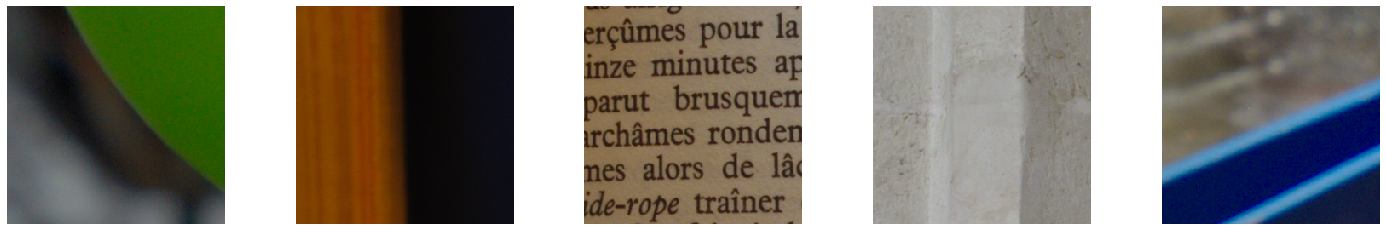

In [7]:
plot_images(x_train_clean) 

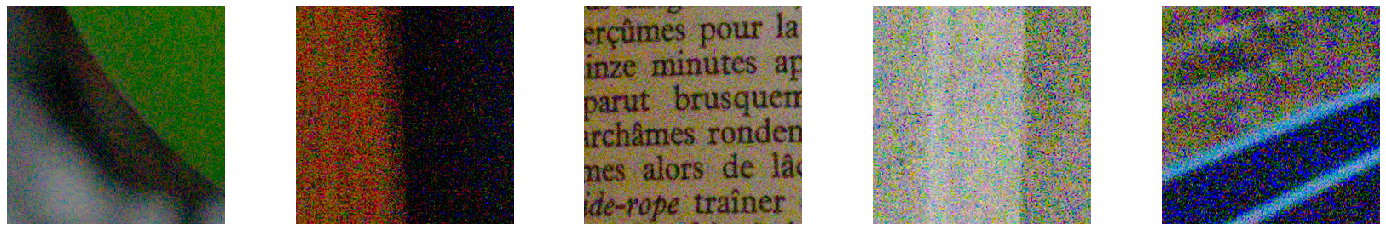

In [8]:
plot_images(x_train_noisy) 

In [9]:
# Normalize data
x_train_clean = [(i / 255) for i in x_train_clean]
x_train_noisy = [(i / 255) for i in x_train_noisy]

For the N2C model, we will be training on noisy and clean image pairs. Noisy images will be fed into the model and the base ISO images will be the targets for the model.

The below is our implementation for the paper's autoencoder u-net model, with optional blind spot.

In [10]:
# Backbone autoencoder network, optional blind spot.
blindspot = False

def up(n):
    s = tf.shape(n)
    s = [-1, n.shape[1], s[2], s[3]]
    n = tf.reshape(n, [s[0], s[1], s[2], 1, s[3], 1])
    n = tf.tile(n, [1, 1, 1, 2, 1, 2])
    n = tf.reshape(n, [s[0], s[1], s[2] * 2, s[3] * 2])
    return n

def down(n):
    n = tf.pad(n[:, :, :-1, :], [[0, 0], [0, 0], [1, 0], [0, 0]])
    n = tf.nn.max_pool(n, ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format='NHWC')
    return n

def rotate(x, angle):
    if   angle == 0:   return x
    elif angle == 90:  return tf.transpose(x[:, :, :, ::-1], [0, 1, 2, 3])
    elif angle == 180: return x[:, :, ::-1, ::-1]
    elif angle == 270: return tf.transpose(x[:, :, ::-1, :], [0, 1, 2, 3])

def concat(layers):
    return tf.concat(layers, axis=3)

def input_rotation(n):
    return tf.concat([rotate(n, a) for a in [0, 90, 180, 270]], axis=3)

def output_rotation(n):
    return tf.concat([rotate(n, a) for a in [0, 270, 180, 90]], axis=3)

def rotate90(x):
    return tf.transpose(x[:, :, :, ::-1], [0, 1, 2, 3])

def rotate180(x):
    return x[:, :, ::-1, ::-1]

def rotate270(x):
    return tf.transpose(x[:, :, ::-1, :], [0, 1, 2, 3])

def shift_and_pad(x):
    return tf.pad(x[:, :, :-1, :], [[0, 0], [0, 0], [1, 0], [0, 0]])

def split(x):
    return tf.split(x, 4, axis=3)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:104: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ni...)`
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ni...)`


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
enc_conv0 (Conv2D)              (None, 256, 256, 48) 1344        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 48) 0           enc_conv0[0][0]                  
__________________________________________________________________________________________________
enc_conv1 (Conv2D)              (None, 256, 256, 48) 20784       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

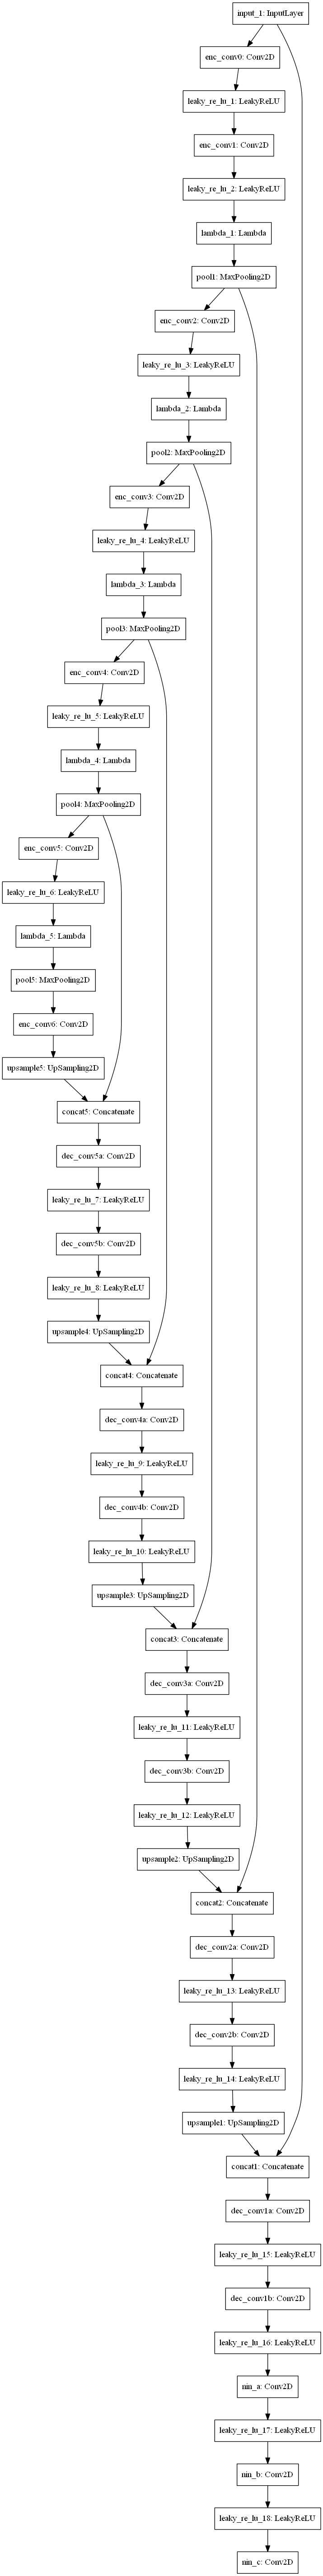

In [11]:
# Input stage
inputs = Input(input_shape)

if not blindspot:
    x = inputs
else:
    x = Lambda(input_rotation, name='rotate_inputs')(inputs)

# Encoder part
pool0 = x
x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv0')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv1')(x)
x = LeakyReLU(alpha=0.1)(x)  
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool1')(x); pool1 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool2')(x); pool2 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv3')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool3')(x); pool3 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv4')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool4')(x); pool4 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Lambda(shift_and_pad)(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding = 'same', data_format='channels_last', name='pool5')(x); pool5 = x

x = Conv2D(48, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='enc_conv6')(x)

# Decoder part
x = UpSampling2D(size = (1, 2), name='upsample5')(x)
x = concatenate([x, pool4], axis=3, name='concat5')
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv5a')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv5b')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D(size = (1, 2), name='upsample4')(x)
x = concatenate([x, pool3], axis=3, name='concat4')
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv4a')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv4b')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D(size = (1, 2), name='upsample3')(x)
x = concatenate([x, pool2], axis=3, name='concat3')
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv3a')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv3b')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D(size = (1, 2), name='upsample2')(x)
x = concatenate([x, pool1], axis=3, name='concat2')
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv2a')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv2b')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D(size = (1, 2), name='upsample1')(x)
x = concatenate([x, pool0], axis=3, name='concat1')

# Output stages

if blindspot:
    # Blind-spot output stages
    x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv1a')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv1b')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Lambda(shift_and_pad, name='shift_and_pad')(x)
    x = Lambda(split, name='split')(x)
    rot90s = Lambda(rotate90)(x[3])
    rot180s = Lambda(rotate180)(x[2])
    rot270s = Lambda(rotate270)(x[1])
    x = concatenate([x[0], rot90s, rot180s, rot270s], axis=3)   # Combine on channel axis.
    x = Conv2D(96*4, 1, strides=(1, 1), padding = 'same', data_format='channels_last', name='nin_a')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96, 1, strides=(1, 1), padding = 'same', data_format='channels_last', name='nin_b')(x)
    x = LeakyReLU(alpha=0.1)(x)
    outputs = Conv2D(3, 1, activation = 'linear', name='nin_c')(x)

else:
    # Baseline network with postprocessing layers -- keep feature maps and distill with 1x1 convolutions
    x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv1a')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96, 3, strides=(1, 1), padding = 'same', data_format='channels_last', name='dec_conv1b')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96*4, 1, strides=(1, 1), padding = 'same', data_format='channels_last', name='nin_a')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(96, 1, strides=(1, 1), padding = 'same', data_format='channels_last', name='nin_b')(x)
    x = LeakyReLU(alpha=0.1)(x)
    outputs = Conv2D(3, 1, activation = 'linear', name='nin_c')(x)

model = Model(input = inputs, output = outputs)
model_img = Model(input = inputs, output = outputs)

# Summarize layers
print(model.summary())

# Plot model architecture
plot_model(model, to_file='shared_input_layer.png')

In [12]:
# Save model architecture to JSON
model_json = model.to_json()
with open("n2n_n2c_no_blindspot_unet_model.json", "w") as json_file:
    json_file.write(model_json)

We define a set of different metrics for comparison and to measure the model's performance.

In [13]:
def MSE(pure, target):
    return mean_squared_error(pure, target)

def PSNR(pure, target):
    max_pixel = 1.0
    return (tf.image.psnr(pure, target, max_pixel))

def SSIM(pure, target):
    return tf.image.ssim(pure, target, max_val = 1)

def SSIM_cv(pure, target):
    return structural_similarity(pure, target, dynamic_range=1, multichannel=True)

The model is then trained and saved below. As there are only 79 full-sized 8-bit images from the NIND dataset to train from, we will train for 1000 epoches.

In [14]:
adam = optimizers.Adam(learning_rate=0.0003)

def train_and_save(model, path, history_path, **kwargs):
    if path.exists() and history_path.exists():
        model.load_weights(str(path))
        history=pd.read_csv(str(history_path), sep=',')  
        return history
    else:
        model.compile(optimizer=adam, loss='mean_squared_error', metrics=[PSNR, SSIM, 'mse'])
        history = model.fit(**kwargs)
        model.save_weights(str(path))
        history = pd.DataFrame(history.history)
        history.to_csv(str(history_path), sep=',')
        return history

In [15]:
# Using the paper's Gaussian N2C network (Varying Sigma of 5 to 50)
history_bs = train_and_save(
    model=model,
    path=Path('./n2c_NIND.h5'),
    history_path=Path('./n2c_NIND_hist.csv'),
    x=np.array(x_train_noisy),
    y=np.array(x_train_clean), # x_train for N2C
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    epochs=1000,
    callbacks=[TqdmCallback(verbose=1)],
)

We plot the history graphs for loss and each metric to see if our model converges well after training and if we have overfitted or underfitted.

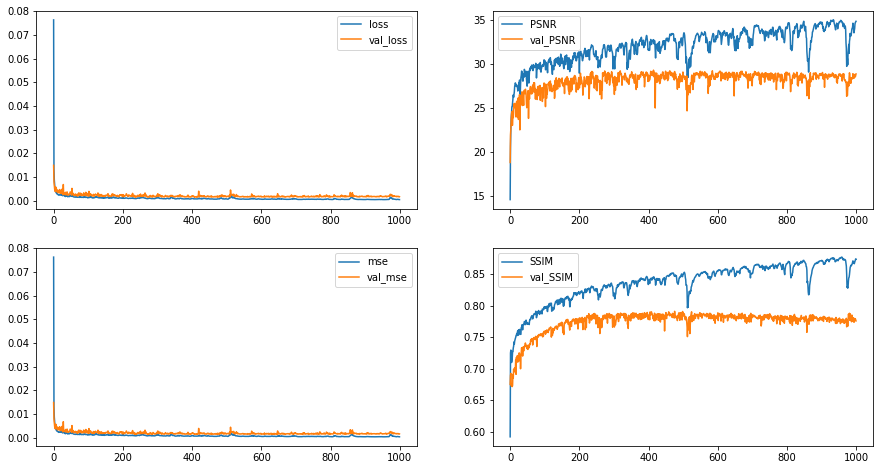

In [16]:
# Using the paper's Gaussian N2C network (Varying Sigma of 5 to 50)
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
history_bs.plot(y=['loss', 'val_loss'], ax=ax[0, 0])
history_bs.plot(y=['PSNR', 'val_PSNR'], ax=ax[0, 1])
history_bs.plot(y=['mse', 'val_mse'], ax=ax[1, 0])
history_bs.plot(y=['SSIM', 'val_SSIM'], ax=ax[1, 1]);

In [17]:
pd.set_option('display.max_rows', None)
history_bs

Unnamed: 0  val_loss   val_PSNR  val_SSIM   val_mse      loss       PSNR  \
0             0  0.014887  18.790752  0.675116  0.014887  0.076321  14.555987   
1             1  0.008024  21.966780  0.689210  0.008024  0.013294  20.565079   
2             2  0.006341  22.650043  0.692579  0.006341  0.008674  22.692940   
3             3  0.004731  23.676069  0.672817  0.004731  0.006452  23.899050   
4             4  0.004119  24.314241  0.673075  0.004119  0.004822  24.432673   
5             5  0.003788  24.578615  0.674356  0.003788  0.004050  25.147224   
6             6  0.005749  23.025345  0.671641  0.005749  0.003857  25.174229   
7             7  0.005492  23.054640  0.673680  0.005492  0.003404  25.612043   
8             8  0.003907  24.676903  0.690915  0.003907  0.003385  25.918627   
9             9  0.004759  23.904686  0.685227  0.004759  0.002877  26.499546   
10           10  0.004094  24.483967  0.699228  0.004094  0.003054  26.224436   
11           11  0.003389  25.481380  0.694643  0.003389  0.002964  26.496170   
12           12  0.003561  25.177498  0.698190  0.003561  0.002728  26.836096   
13           13  0.003369  25.526611  0.701538  0.003369  0.002511  27.460938   
14           14  0.004042  25.050972  0.699209  0.004042  0.002288  27.677368   
15           15  0.003783  25.035244  0.700029  0.003783  0.002397  27.869614   
16           16  0.003989  24.915443  0.714045  0.003989  0.002396  27.723581   
17           17  0.004652  23.973848  0.691032  0.004652  0.002451  27.495970   
18           18  0.003390  25.618961  0.717835  0.003390  0.002327  27.676556   
19           19  0.003011  25.776997  0.711388  0.003011  0.002471  27.594919   
20           20  0.003308  25.026518  0.716408  0.003308  0.002387  27.424271   
21           21  0.003131  25.705727  0.720812  0.003131  0.002494  27.466066   
22           22  0.004512  23.929892  0.710402  0.004512  0.002863  26.940752   
23           23  0.003043  26.147272  0.716534  0.003043  0.002443  27.244381   
24           24  0.004784  23.697376  0.714040  0.004784  0.002788  27.251423   
25           25  0.003150  25.329107  0.718175  0.003150  0.002148  27.907513   
26           26  0.003574  25.276423  0.725096  0.003574  0.002166  27.870470   
27           27  0.002486  26.521660  0.723486  0.002486  0.002031  28.190216   
28           28  0.006783  22.508507  0.712384  0.006783  0.002367  28.091751   
29           29  0.002945  25.663780  0.722448  0.002945  0.003014  26.403744   
30           30  0.003148  25.409794  0.699853  0.003148  0.002384  27.674040   
31           31  0.002873  26.430943  0.717816  0.002873  0.002078  28.462570   
32           32  0.003037  26.013577  0.726022  0.003037  0.002248  28.717512   
33           33  0.002773  26.356447  0.733148  0.002773  0.001781  29.211313   
34           34  0.002491  26.845175  0.729484  0.002491  0.001707  29.176023   
35           35  0.003512  25.282547  0.726322  0.003512  0.001881  28.830513   
36           36  0.003035  26.226835  0.719950  0.003035  0.002262  28.115749   
37           37  0.002460  26.788162  0.723772  0.002460  0.002128  28.064535   
38           38  0.003038  25.984880  0.734755  0.003038  0.001812  28.861694   
39           39  0.003665  25.310192  0.727940  0.003665  0.001932  28.485216   
40           40  0.002419  27.011091  0.733081  0.002419  0.001875  28.519264   
41           41  0.002342  26.994684  0.735358  0.002342  0.001576  29.410954   
42           42  0.002455  26.764963  0.735865  0.002455  0.001720  29.253996   
43           43  0.002706  26.636494  0.735597  0.002706  0.001929  28.614824   
44           44  0.002418  27.149315  0.740692  0.002418  0.001860  29.058331   
45           45  0.002588  26.939346  0.735066  0.002588  0.001656  29.109497   
46           46  0.002774  26.627846  0.737277  0.002774  0.001744  29.189589   
47           47  0.002995  25.533291  0.736474  0.002995  0.001943  28.319277   
48           48  0.003679  25.033604

The denoised images for the training set are generated by passing the noisy images through the trained model.

In [18]:
# Generate denoised NIND images
samples_g = np.array(x_train_noisy)
denoised_images = model.predict(samples_g)

In [19]:
# Calculate Average MSE
def calc_avg_mse(true_imgs, measured_imgs):
    mse_summed = 0
    for i in range(0, len(measured_imgs)):
        mse_summed += MSE(true_imgs[i], measured_imgs[i])
    return (mse_summed/len(measured_imgs))

# Calculate Average PSNR
def calc_avg_psnr(true_imgs, measured_imgs):
    pnsr_summed = 0
    for i in range(0, len(measured_imgs)):
        pnsr_summed += PSNR(true_imgs[i], measured_imgs[i])
    return (pnsr_summed.numpy()/len(measured_imgs))

# Calculate Average Structural Similarity Index
def calc_avg_ssim(true_imgs, measured_imgs):
    ssim_summed = 0
    for i in range(0, len(measured_imgs)):
        ssim_summed += SSIM_cv(true_imgs[i], measured_imgs[i])
    return (ssim_summed/len(measured_imgs))

In [20]:
def calc_avg_metrics(pure, all_noisy_images, all_denoised_images):
    noisy_psnrs = pd.DataFrame({"Noisy Images (PSNR)": [calc_avg_psnr(pure, i) for i in all_noisy_images]})
    noisy_mses = pd.DataFrame({"Noisy Images (MSE)": [calc_avg_mse(pure, i) for i in all_noisy_images]})
    noisy_ssims = pd.DataFrame({"Noisy Images (SSIM)": [calc_avg_ssim(pure, i) for i in all_noisy_images]})
    denoised_psnrs = pd.DataFrame({"Denoised Images (PSNR)": [calc_avg_psnr(pure, i) for i in all_denoised_images]})
    denoised_mses = pd.DataFrame({"Denoised Images (MSE)": [calc_avg_mse(pure, i) for i in all_denoised_images]})
    denoised_ssims = pd.DataFrame({"Denoised Images (SSIM)": [calc_avg_ssim(pure, i) for i in all_denoised_images]}) 
    compare_psnrs = pd.concat([noisy_psnrs, denoised_psnrs, noisy_mses, denoised_mses, noisy_ssims, denoised_ssims], axis=1)
    compare_psnrs.index = ['N2C Model']
    return compare_psnrs.round(3)

In [21]:
# Results for training images
calc_avg_metrics(x_train_clean, [x_train_noisy], [denoised_images])

C:\Anaconda\lib\site-packages\skimage\metrics\_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Noisy Images (PSNR)  Denoised Images (PSNR)  Noisy Images (MSE)  \
N2C Model                 21.4                  33.763               0.013   

           Denoised Images (MSE)  Noisy Images (SSIM)  Denoised Images (SSIM)  
N2C Model                  0.001                0.513                   0.933

Comparing the trained N2C model using real-life images on the paper's and our results from different generated noise profiles, we can see that the performance is similar.

In [22]:
compare_denoised_both=pd.read_csv('./denoised_metrics_from_both.csv', sep=',', index_col=0)  
compare_denoised_both.iloc[:,0:2].round(3)

Denoised Images, Paper (PSNR)  Denoised Images, Ours (PSNR)
gauss5_50_n2n                            33.437                        30.393
gauss5_50_n2c                            33.444                        31.462
poisson5_50_n2n                          30.911                        20.283
poisson5_50_n2c                          30.915                        33.830
impulse0_100_n2n                         33.092                        18.292
impulse0_100_n2c                         33.327                        29.044

Visualising the denoised NIND images.

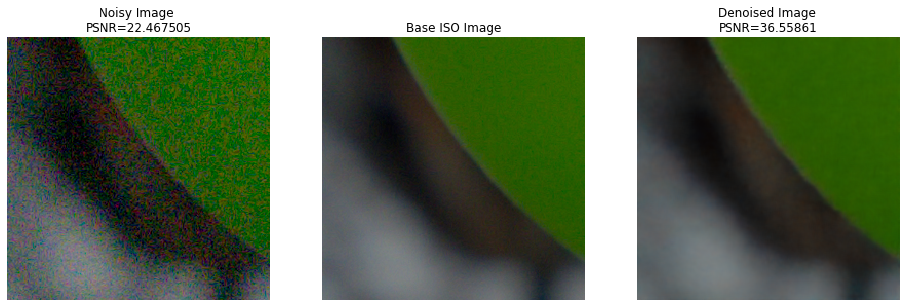

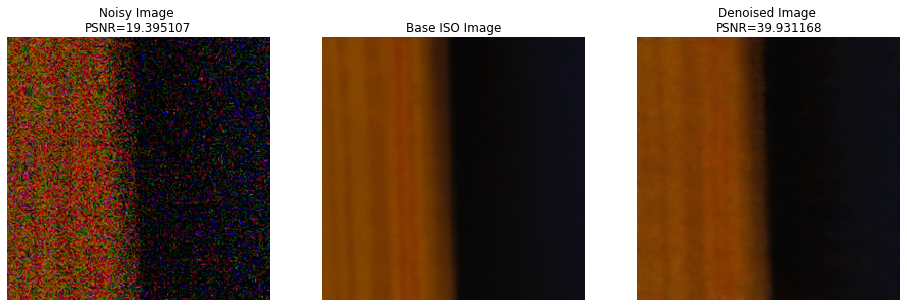

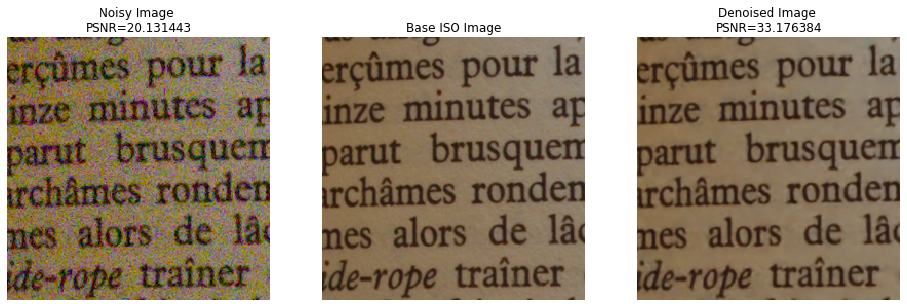

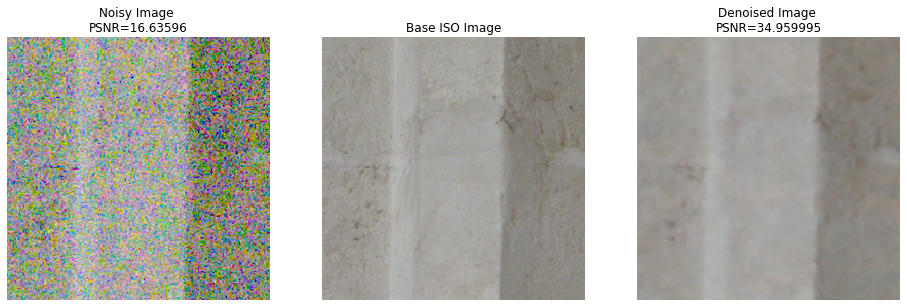

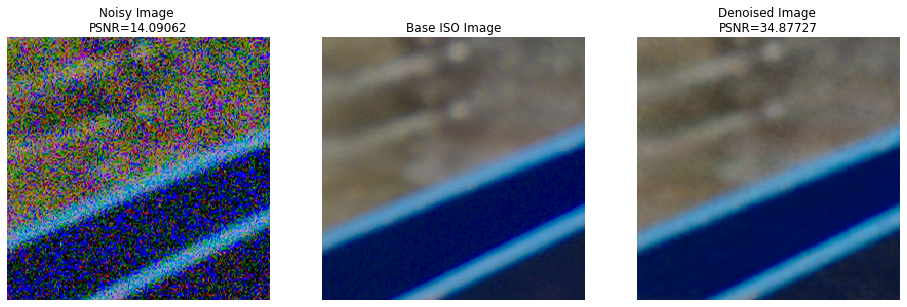

In [23]:
# Plot denoised NIND images
for i in range(0, 5):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(16, 16)

    axes[0].imshow(x_train_noisy[i])
    axes[0].set_title('Noisy Image \nPSNR='+str(PSNR(x_train_clean[i], x_train_noisy[i]).numpy()))
    axes[1].imshow(x_train_clean[i])
    axes[1].set_title('Base ISO Image')
    axes[2].imshow(denoised_images[i])
    axes[2].set_title('Denoised Image \nPSNR='+str(PSNR(x_train_clean[i], denoised_images[i]).numpy()))
    axes[0].axis('off'); axes[1].axis('off'); axes[2].axis('off'); 
    plt.show();

We can apply the trained model on a real-world, full-sized image to evaluate its denoising performance.

In [66]:
# Showcase Image Parameters
img_width, img_height = 4800, 3200
input_shape = (img_width, img_height, 3)

In [122]:
noisy_image = cv2.cvtColor(cv2.resize(cv2.imread('C:/NIND_datasets/NIND_noisy/NIND_MVB-Urania_ISOH2.jpg', cv2.IMREAD_COLOR), (img_width, img_height)), cv2.COLOR_BGR2RGB) / 255
base_image = cv2.cvtColor(cv2.resize(cv2.imread('C:/NIND_datasets/NIND_base_iso/NIND_MVB-Urania_ISO200.jpg', cv2.IMREAD_COLOR), (img_width, img_height)), cv2.COLOR_BGR2RGB) / 255

Full sized image visualisations.

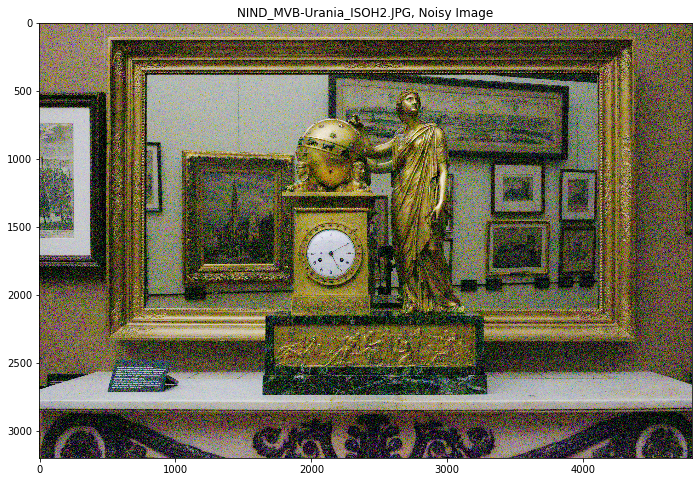

In [123]:
plt.figure(figsize = (20,8))
plt.title('NIND_MVB-Urania_ISOH2.JPG, Noisy Image')
plt.imshow(noisy_image)
plt.show()

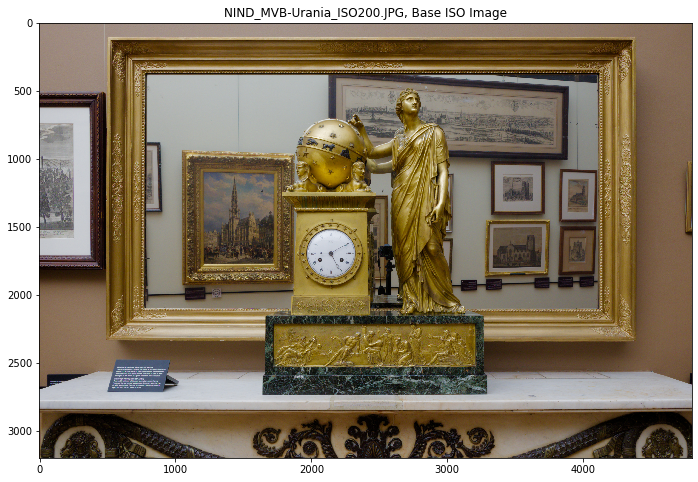

In [124]:
plt.figure(figsize = (20,8))
plt.title('NIND_MVB-Urania_ISO200.JPG, Base ISO Image')
plt.imshow(base_image)
plt.show()

In [125]:
model_img.load_weights(str(Path('./n2c_NIND.h5'))) # Need to reload model for this
denoised_image = model_img.predict(np.array([np.rot90(noisy_image)]))
denoised_image = np.rot90(np.rot90(np.rot90(denoised_image[0])))

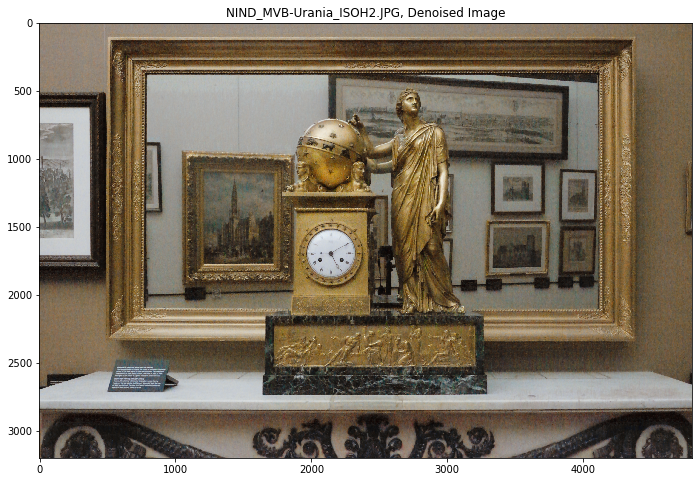

In [126]:
plt.figure(figsize = (20,8))
plt.title('NIND_MVB-Urania_ISOH2.JPG, Denoised Image')
plt.imshow(denoised_image)
plt.show()

In [127]:
crop_base = base_image[500:500+256, 2600:2600+256]
crop_noisy = noisy_image[500:500+256, 2600:2600+256]
crop_denoised = denoised_image[500:500+256, 2600:2600+256]

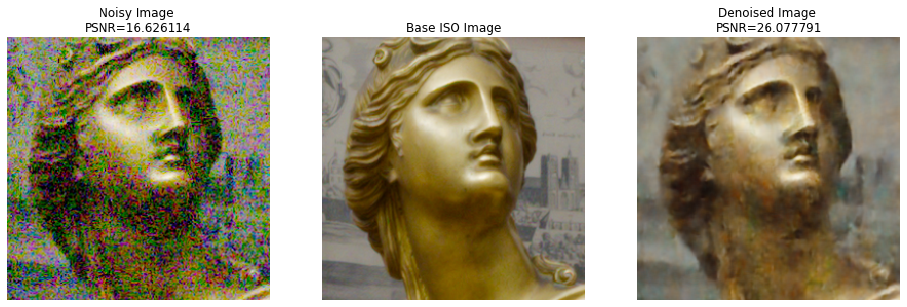

In [128]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(16, 16)

axes[0].imshow(crop_noisy)
axes[0].set_title('Noisy Image \nPSNR='+str(PSNR(base_image, noisy_image).numpy()))
axes[1].imshow(crop_base)
axes[1].set_title('Base ISO Image')
axes[2].imshow(crop_denoised)
axes[2].set_title('Denoised Image \nPSNR='+str(PSNR(base_image, denoised_image).numpy()))
axes[0].axis('off'); axes[1].axis('off'); axes[2].axis('off'); 
plt.show();